Take random picture from test dataset

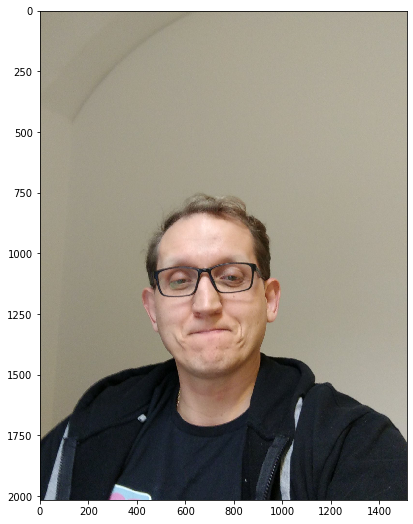

In [12]:
import os, random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter, ExifTags

folder=r"dataset_test"
source_image = Image.open(folder+'/'+random.choice(os.listdir(folder)))

def reorient_image(im):
    try:
        image_exif = im._getexif()
        image_orientation = image_exif[274]
        if image_orientation in (2,'2'):
            return im.transpose(Image.FLIP_LEFT_RIGHT)
        elif image_orientation in (3,'3'):
            return im.transpose(Image.ROTATE_180)
        elif image_orientation in (4,'4'):
            return im.transpose(Image.FLIP_TOP_BOTTOM)
        elif image_orientation in (5,'5'):
            return im.transpose(Image.ROTATE_90).transpose(Image.FLIP_TOP_BOTTOM)
        elif image_orientation in (6,'6'):
            return im.transpose(Image.ROTATE_270)
        elif image_orientation in (7,'7'):
            return im.transpose(Image.ROTATE_270).transpose(Image.FLIP_TOP_BOTTOM)
        elif image_orientation in (8,'8'):
            return im.transpose(Image.ROTATE_90)
        else:
            return im
    except (KeyError, AttributeError, TypeError, IndexError):
        return im

source_image = reorient_image(source_image)
plt.figure(figsize=(9, 9))
plt.imshow(source_image)

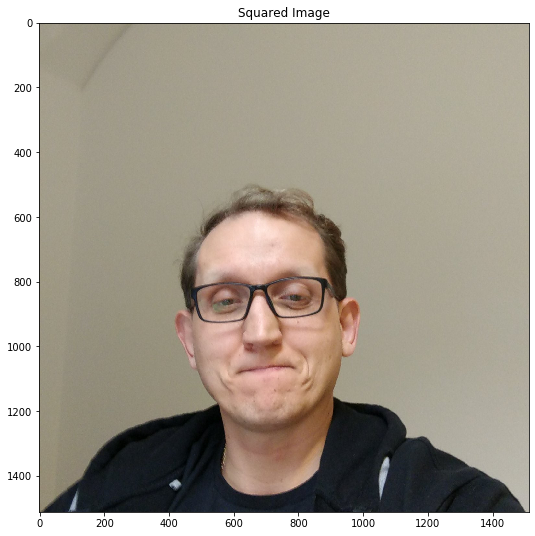

In [13]:
squared_size = min(source_image.width,source_image.height), min(source_image.width,source_image.height)
squared_image = ImageOps.fit(source_image, squared_size, Image.ANTIALIAS)

plt.figure(figsize=(9, 9))
plt.title('Squared Image')
plt.imshow(squared_image)

(256, 256, 3)


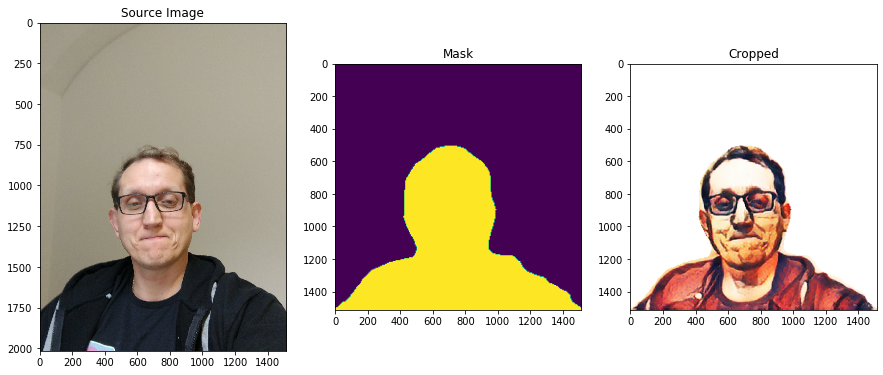

In [19]:
import numpy as np
import tensorflow as tf
import cv2

# Increase brightness
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# Get segmentation Mask
def get_segmentation_mask(input_image):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path="models/deeplabv3_257_mv_gpu.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # Prepear input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(input_image, dtype=np.float32).reshape(input_shape)
    # Normalised [-1,1]
    input_data = 2.*(input_data - np.min(input_data))/np.ptp(input_data)-1
    interpreter.set_tensor(input_details[0]['index'], input_data)
    # Run model.
    interpreter.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # Get mask image
    return tf.keras.preprocessing.image.array_to_img(create_mask(output_data))

# Get image with applied Style
def get_styled_image(input_image):
    # Load Style
    style_predict_size = 256, 256
    style_predict_image = ImageOps.fit(input_image, style_predict_size, Image.ANTIALIAS)
    
    # Increase brightness
    cv_style = cv2.cvtColor(np.array(style_predict_image), cv2.COLOR_RGBA2BGR)
    cv_style = increase_brightness(cv_style,100)
    cv_style = cv2.cvtColor(cv_style, cv2.COLOR_BGR2RGB)
    style_predict_image = Image.fromarray(cv_style)
    
    # Load TFLite model and allocate tensors.
    style_predict_interpreter = tf.lite.Interpreter(model_path="models/style_predict_quantized_256.tflite")
    style_predict_interpreter.allocate_tensors()
    # Get input and output tensors.
    style_predict_input_details = style_predict_interpreter.get_input_details()
    style_predict_output_details = style_predict_interpreter.get_output_details()
    # Prepear input data.
    style_predict_input_shape = style_predict_input_details[0]['shape']
    print(np.array(style_predict_image, dtype=np.float32).shape)
    style_predict_input_data = np.array(style_predict_image, dtype=np.float32).reshape(style_predict_input_shape)
    # Normalised [-1,1]
    style_predict_input_data = 2.*(style_predict_input_data - np.min(style_predict_input_data))/np.ptp(style_predict_input_data)-1
    style_predict_interpreter.set_tensor(style_predict_input_details[0]['index'], style_predict_input_data)
    # Run model.
    style_predict_interpreter.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    style_predict_output_data = style_predict_interpreter.get_tensor(style_predict_output_details[0]['index'])
    
    # Applay to image
    transfer_size = 384, 384
    transfer_image = ImageOps.fit(input_image, transfer_size, Image.ANTIALIAS)
    # Load TFLite model and allocate tensors.
    transfer_interpreter = tf.lite.Interpreter(model_path="models/style_transfer_quantized_dynamic.tflite")
    transfer_interpreter.allocate_tensors()
    # Get input and output tensors.
    transfer_input_details = transfer_interpreter.get_input_details()
    transfer_output_details = transfer_interpreter.get_output_details()
    # Prepear input data.
    transfer_input_shape = transfer_input_details[0]['shape']
    transfer_input_data = np.array(transfer_image, dtype=np.float32).reshape(transfer_input_shape)
     # Normalised [-1,1]
    transfer_input_data = 2.*(transfer_input_data - np.min(transfer_input_data))/np.ptp(transfer_input_data)-1
    transfer_interpreter.set_tensor(transfer_input_details[0]['index'], transfer_input_data)
    transfer_interpreter.set_tensor(transfer_input_details[1]['index'], style_predict_output_data)
    # Run model.
    transfer_interpreter.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    transfer_output_data = transfer_interpreter.get_tensor(transfer_output_details[0]['index'])
    
    return tf.keras.preprocessing.image.array_to_img(transfer_output_data.reshape(transfer_size[0],transfer_size[1],3))

# Argmax for mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# Display data
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Source Image', 'Mask', 'Cropped']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
  plt.show()

first_opencv_image = cv2.cvtColor(np.array(source_image), cv2.COLOR_RGBA2BGR)
blurred_opencv_image = cv2.GaussianBlur(first_opencv_image,(21,21),0)
# blurred_opencv_image=cv2.bilateralFilter(first_opencv_image, 21,45,45)
blurred_opencv_image = cv2.cvtColor(blurred_opencv_image, cv2.COLOR_BGR2RGB)

styled_img = get_styled_image(squared_image)
styled_img = styled_img.resize(squared_image.size,Image.BILINEAR)

blurred_img = Image.fromarray(blurred_opencv_image)
size = 257, 257
thumb = ImageOps.fit(blurred_img, size, Image.ANTIALIAS)

mask_im = get_segmentation_mask(thumb)

resized_mask = mask_im.resize(squared_image.size,Image.BILINEAR)
resized_cropped_styled_im = Image.composite(styled_img.convert("RGB"), 
                                     Image.new("RGB", squared_image.size, (255, 255, 255)), 
                                     resized_mask.convert("L"))

display([source_image,resized_mask,resized_cropped_styled_im])

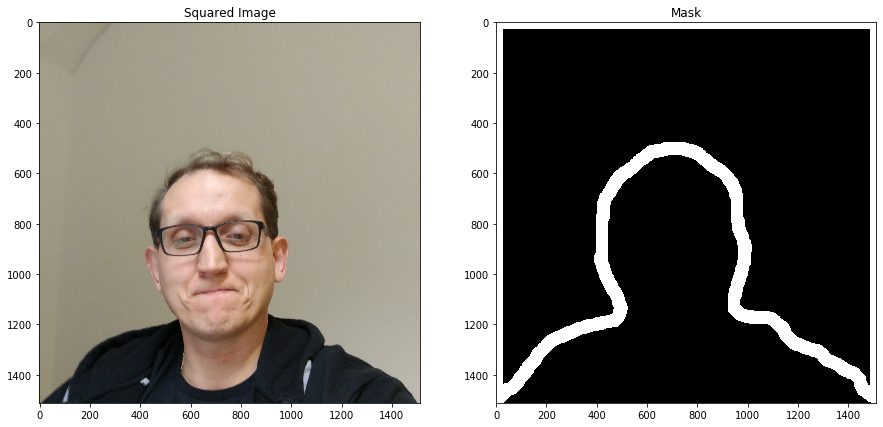

In [20]:

opencv_image = cv2.cvtColor(np.array(resized_cropped_styled_im), cv2.COLOR_RGBA2BGRA)


mask = np.array(Image.new("RGBA", squared_image.size, (0, 0, 0)))

gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Make contours size depend on resolution
cv2.drawContours(mask, contours, -1, (255,255,255),50)

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.title('Squared Image')
plt.imshow(squared_image)

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)




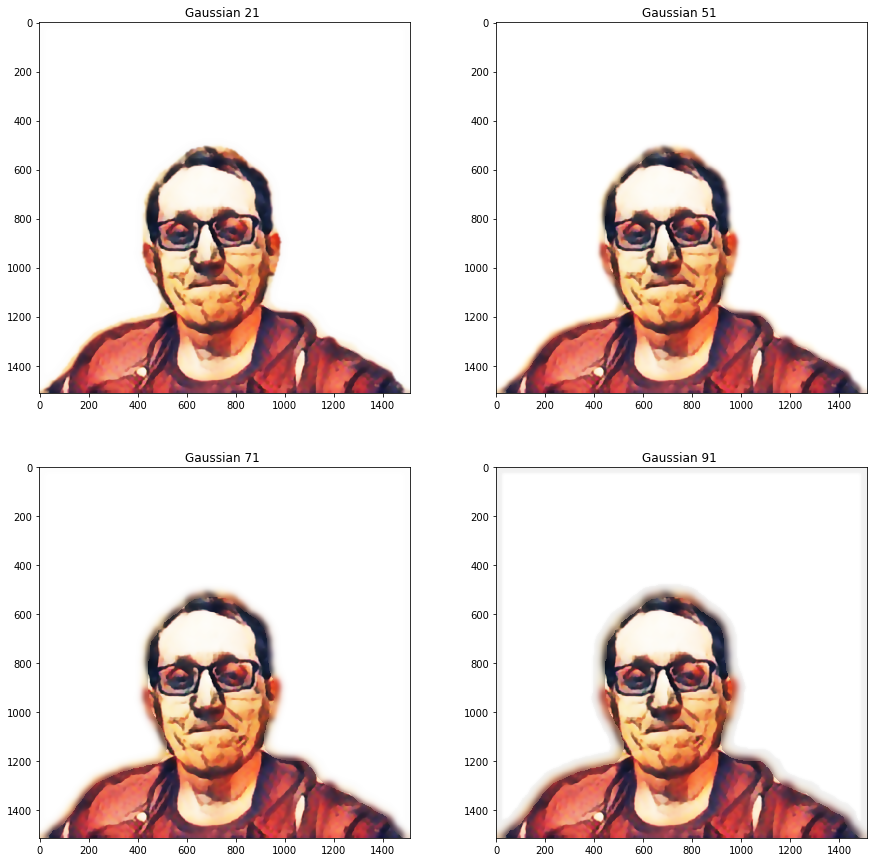

In [21]:
# Display data
def display_with_diffrent_blur(cv_image):
  plt.figure(figsize=(15, 15))
  index = 1
  sigmas = [21, 51, 71, 91]
  for i in sigmas:
    blurred_ga = cv2.GaussianBlur(cv_image,(i,i),0)
    output_ga = np.where(mask==np.array([255, 255, 255,255]), blurred_ga, cv_image)
    output_ga = cv2.cvtColor(output_ga, cv2.COLOR_BGRA2BGR)
    output_ga = cv2.bilateralFilter(output_ga, 21,45,45)
    output_ga = cv2.cvtColor(output_ga, cv2.COLOR_BGR2RGBA)
    plt.subplot(2, 2, index)
    index = index+1
    plt.title("Gaussian {} ".format(i))
    plt.imshow(output_ga)
  plt.show()

display_with_diffrent_blur(opencv_image)
